# Configuracion

In [ ]:
#!pip install --upgrade --force-reinstall torch --index-url https://download.pytorch.org/whl/cu118

In [ ]:
#Check Versions

import sys
import matplotlib
import numpy
import torch

print("Python version:", sys.version)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", numpy.__version__)
print("PyTorch version:", torch.__version__)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Matplotlib version: 3.10.0
NumPy version: 1.26.4
PyTorch version: 2.6.0+cu124


In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

#Plot Config
plt.rcParams["figure.figsize"] = (12, 6)

#Iterative Methods Global Params
tol = 10e-6

#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

# Métodos de Proyecciones Alternantes

## Métodos que convergen para SEL consistentes

### Kacmarz Clasico (1937)

In [ ]:
def classic_kacmarz(A, b, x0=None, max_iter=None, tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  max_iter = max_iter if max_iter is not None else 10 * m

  # OPTION: Precompute a_dot_a for each row in A to avoid redundant calculations
  # a_dot_a = torch.sum(A.pow(2), dim=1)

  k = 0
  b_norm = torch.norm(b)
  r = torch.norm(b - A @ x)/ b_norm
  while r > tol and k < max_iter:
    i = k % m
    a_i = A[i]
    x += (b[i] - torch.dot(a_i, x)) * a_i / torch.sum(a_i.pow(2))
    k += 1
    r = torch.norm(b - A @ x)/ b_norm

  return x, k

### Random Kaczmarz (2007)

In [ ]:
def random_kacmarz(A, b, x0=None, max_iter=None, tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  max_iter = max_iter if max_iter is not None else 10 * m

  A_frob = torch.norm(A, p='fro')**2
  probs = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])

  k = 0
  r = torch.norm(b - A @ x)/torch.norm(b)
  while r > tol and k < max_iter:
    i = torch.multinomial(probs, 1)[0]
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    a_dot_a = torch.sum(a_i**2)
    x += ((b[i] - a_dot_x) / a_dot_a) * a_i
    k += 1
    r = torch.norm(b - A @ x)/torch.norm(b)

  return x, k

### Random Kacmarz por Bloques (2014)

In [ ]:
def random_block_kacmarz(A, b, x0=None, tol=tol, max_iter=None, block_size=25):
    m, d = A.shape
    x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
    max_iter = max_iter if max_iter is not None else 10 * m

    A_frob = torch.norm(A, p='fro')**2
    num_blocks = (m + block_size - 1) // block_size  # Calculate number of blocks
    probs = torch.zeros(num_blocks, dtype=torch.float64, device=A.device)  # Initialize probabilities

    # Divide the rows of the matrix into
    for j in range(num_blocks):
      start_row = j * block_size
      end_row = min((j + 1) * block_size, m)
      A_block = A[start_row:end_row]
      block_frob = torch.norm(A_block, p='fro')**2
      probs[j] = block_frob / A_frob

    k = 0
    r = torch.norm(b - A @ x) / torch.norm(b)
    while (r > tol or k < num_blocks ) and k < max_iter:
        j = torch.multinomial(probs, 1)[0]  # Select a block index
        start_row = j * block_size
        end_row = min((j + 1) * block_size, m)
        A_block = A[start_row:end_row]
        b_block = b[start_row:end_row]

        # Project onto the block:
        x += torch.linalg.pinv(A_block) @ (b_block - A_block @ x)

        k += 1
        r = torch.norm(b - A @ x) / torch.norm(b)

    return x, k

### Greedy Randomized Kaczmarz (2018)

In [ ]:
def greedy_random_kacmarz(A, b, x0=None, max_iter=None, tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  max_iter = max_iter if max_iter is not None else 10 * m

  A_frob_inv = 1/(torch.norm(A, p='fro')**2)
  row_norms = torch.sum(A**2, dim=1)  # Auxiliary vector

  #Calculate residual
  r = b - torch.matmul(A, x)
  r_norm = torch.sum(r**2)
  r_squared = r**2
  #B = torch.mm(A, A.t())

  k = 0
  while r_norm > tol and k < max_iter:
    # Get epsilon
    l = r_squared / row_norms
    eps = 0.5*(1/r_norm * torch.max(l) + A_frob_inv)
    #Check if ik doesnt belong to the index set Uik
    mask = r_squared < eps * r_norm * row_norms
    r_aux = r.clone()
    r_aux[mask] = 0

    #Compute probabilities array
    probs = (r_aux**2) / torch.sum(r_aux**2)

    #Project row
    i = torch.multinomial(probs, 1)[0]
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    x += ((b[i] - a_dot_x) / row_norms[i]) * a_i

    r = b - torch.matmul(A, x)
    #r = r - (r[i]/row_norms[i])*B[i]
    r_norm = torch.sum(r**2)
    r_squared = r**2
    k+=1

  return x, k

## Métodos que convergen para sistemas incosistentes

### Extended Random Kacmarz (2013)

In [ ]:
def extended_random_kacmarz(A, b, x0=None, max_iter=int(1e7), tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  max_iter = max_iter if max_iter is not None else 10 * m

  z = b.clone()
  A_frob = torch.norm(A, p='fro')**2
  probs_p = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])
  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])

  k = 0
  r = torch.norm(b - A @ x)/torch.norm(b)
  while r > tol and k < max_iter:
    x_old = x.clone()

    i = torch.multinomial(probs_p, 1)[0]
    j = torch.multinomial(probs_q, 1)[0]
    a_i = A[i]
    a_j = A[:, j]

    z = z - (torch.dot(a_j, z)/torch.sum(a_j**2))*a_j
    x += ((b[i] - z[i] - torch.dot(a_i, x)) /torch.sum(a_i**2)) * a_i

    k += 1
    r = torch.norm(b - A @ x)/torch.norm(b)

  return x, k

In [ ]:
def REKB(A, B, X0=None, max_iter=None, tol=tol):
  r, m = A.shape
  _, n = B.shape
  max_iter = max_iter if max_iter is not None else  100000 * max(m, n)
  X = X0 if X0 is not None else torch.zeros((m,n), dtype=A.dtype, device=A.device)
  Z = B.clone()

  A_frob = torch.norm(A, p='fro')**2
  probs_p = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])
  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])

  for k in range(max_iter):
    i = torch.multinomial(probs_p, 1)[0]
    j = torch.multinomial(probs_q, 1)[0]

    a_i = A[i]
    a_j = A[:, j]

    Z -= (a_j[:, None] / torch.sum(a_j**2)) @ (a_j @ Z)[None, :]
    X += (a_i[:, None] / torch.sum(a_i**2)) @ (B[i] - Z[i] - torch.matmul(a_i, X))[None, :]

    if torch.norm(B - A @ X)/torch.norm(B) < tol:
      return X, k + 1

  return X, max_iter

### Greedy Extended Random Kaczmarz (2023)

In [ ]:
def extended_greedy_random_kacmarz(A, b, x0=None, max_iter=int(1e7), tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  max_iter = max_iter if max_iter is not None else 10 * m

  z = b.clone()
  A_frob = torch.norm(A, p='fro')**2
  A_frob_inv = 1/A_frob

  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])
  row_norms = torch.sum(A**2, dim=1)  # Auxiliary vector

  #Calculate residual
  r = b - torch.matmul(A, x)
  r_norm = torch.sum(r**2)
  r_squared = r**2
  #B = torch.mm(A, A.t())

  k = 0
  while r_norm > tol and k < max_iter:
    # Get epsilon
    l = r_squared / row_norms
    eps = 0.5*(1/r_norm * torch.max(l) + A_frob_inv)

    #Check if ik doesnt belong to the index set Uik
    mask = r_squared < eps * r_norm * row_norms
    r_aux = r.clone()
    r_aux[mask] = 0

    #Compute probabilities array
    probs = (r_aux**2) / torch.sum(r_aux**2)

    #Project row
    i = torch.multinomial(probs, 1)[0]
    j = torch.multinomial(probs_q, 1)[0]
    a_i = A[i]
    a_j = A[:, j]

    z -= (torch.dot(a_j, z)/torch.sum(a_j**2))*a_j
    x += ((b[i] - z[i] - torch.dot(a_i, x)) /torch.sum(a_i**2)) * a_i

    #r = r - (r[i]/row_norms[i])*B[i]
    r = b - z - torch.matmul(A, x)
    r_norm = torch.sum(r**2)
    r_squared = r**2
    k+=1

  return x, k

### Randomized Double Block Kaczmarz (2015)

In [ ]:
def extended_random_kacmarz_double_block(A, b, x0=None, max_iter=int(1e7), tol=tol, block_size=25):
    m, d = A.shape
    x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
    max_iter = max_iter if max_iter is not None else 10 * m

    z = b.clone()
    A_frob = torch.norm(A, p='fro')**2

    # Calculate probabilities for row blocks
    probs_p = torch.zeros((m + block_size - 1) // block_size )  # Initialize probabilities
    for i_block in range(0, m, block_size):
        block = A[i_block:min(i_block + block_size, m)]
        block_norm_sq = torch.sum(torch.norm(block, dim=1)**2)
        probs_p[i_block // block_size] = block_norm_sq / A_frob
    probs_p /= torch.sum(probs_p)

    # Calculate probabilities for column blocks
    probs_q = torch.zeros((d + block_size - 1) // block_size )
    for j_block in range(0, d, block_size):
        block = A[:, j_block:min(j_block + block_size, d)]
        block_norm_sq = torch.sum(torch.norm(block, dim=0)**2)
        probs_q[j_block // block_size] = block_norm_sq / A_frob
    probs_q /= torch.sum(probs_q)

    k = 0
    r = torch.norm(b - A @ x) / torch.norm(b)
    while (r > tol or k < ((m + block_size - 1) // block_size) ) and k < max_iter:
        x_old = x.clone()
        i_block = torch.multinomial(probs_p, 1)[0] * block_size
        j_block = torch.multinomial(probs_q, 1)[0] * block_size

        i_end = min(i_block + block_size, m)
        j_end = min(j_block + block_size, d)

        A_i = A[i_block:i_end]  # Row block
        A_j = A[:, j_block:j_end]  # Column block

        # Project onto the blocks
        z -=  A_j @ (torch.linalg.pinv(A_j) @ z)
        x += torch.linalg.pinv(A_i) @  (b[i_block:i_end] - z[i_block:i_end] - A_i @ x)

        k += 1
        r = torch.norm(b - A @ x) / torch.norm(b)

    return x, k

## Cimmino

In [ ]:
def cimmino(A, b, x0=None, max_iter=1e6, tol=tol):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)

  M = torch.diag( 1.0 / (m *torch.norm(A, dim=1)**2))
  P = torch.matmul(A.T, M)
  for k in range(int(max_iter)):
    r = b - torch.matmul(A, x)
    x = x + torch.matmul(P, r)
    res = r  @ r.T
    if res < tol:
      return x, k

  return x, max_iter

## Conjugate Gradient Cimmino

In [ ]:
def conjugate_gradient_cimmino(A, b, x0=None, max_iter=int(1e7), tol=tol):
  m, n = A.shape
  x = x0 if x0 is not None else torch.ones(n, dtype=A.dtype, device=A.device).to(device)
  max_iter = max_iter if max_iter is not None else 10 * m

  a_norms =  torch.sum(A**2, dim=1)
  Ax = torch.matmul(A, x)
  numerator_ci = (Ax - b).unsqueeze(1) * A
  ci = x - numerator_ci / torch.sum(A**2, dim=1, keepdim=True)
  Aci = torch.einsum('ij,ji->i', A, ci.T)
  #print("1")
  b = torch.sum((Aci / a_norms)[:, None] * A, dim=0)
  dot_products = Ax / a_norms
  Ax = torch.sum(dot_products[:, None] * A, dim=0)
  r = b - Ax
  p = r
  v = torch.dot(r.T, r)
  #print("2")

  A = A.T @ (A / a_norms[:, None]) #Substitute Matrix A to free space
  # CG Loop
  for k in range(max_iter):
      h = A @ p
      u = torch.dot(p, h)

      alpha = v / u
      x += alpha * p
      r -= alpha * h
      v_next = torch.dot(r, r)

      if torch.sqrt(v_next) < tol:
          return x, k + 1

      beta = v_next / v
      p = r + beta * p
      v = v_next

  return x, k

# Experimentos Proyecciones Alternantes

In [ ]:
import numpy as np
import random
import time
import torch

def generate_SEL(n, m, noiseLev=0.1, noise=False):
    """Generates a matrix A, and a vector b according to the specified procedure. """

    A = np.zeros((n, m))
    for i in range(n):
        mu = random.uniform(-5, 5)
        sigma = random.uniform(1, 20)
        A[i, :] = np.random.normal(mu, sigma, m)

    x = np.zeros(m)
    for i in range(m):
        mu = random.uniform(-5, 5)
        sigma = random.uniform(1, 20)
        x[i] = np.random.normal(mu, sigma)

    b = A @ x

    if(noise):
      e = np.random.normal(0, 1, size=b.shape)
      w = noiseLev * e/np.linalg.norm(e)
      b +=  w

    return A, b

In [ ]:
def benchmark_MAP(solver_function, A, b, num_runs=10):
    """
    Benchmarks a MAP solver function by running it multiple times and
    averaging the execution time and number of iterations.
    """

    total_time = 0
    total_iterations = 0

    for _ in range(num_runs):
        start_time = time.time()
        _, iterations = solver_function(A, b)  # Assuming solver returns (result, iterations)
        end_time = time.time()
        total_time += end_time - start_time
        total_iterations += iterations

    average_time = total_time / num_runs
    average_iterations = total_iterations / num_runs

    return average_time, int(average_iterations)

## Experimento 1: Distribución de los Métodos Aleatorios

---



In [ ]:
import numpy as np
from scipy.stats import shapiro
from scipy import stats

def shapiro_wilk_test(iterations, alpha = 0.2):
  stat, p = shapiro(iterations)

  if p > alpha:
    print("No se rechaza la hipótesis nula. Los datos parecen seguir una distribución normal.")
  else:
    print("Se rechaza la hipótesis nula. Los datos no parecen seguir una distribución normal.")

  return stat, p

def test_normality(data,  alpha = 0.05):
    data = np.array(data)  # Ensure data is a NumPy array
    statistic, p_value = stats.normaltest(data)

    if p_value > alpha:
      print("No se rechaza la hipótesis nula. Los datos parecen seguir una distribución normal.")
    else:
      print("Se rechaza la hipótesis nula. Los datos no parecen seguir una distribución normal.")

    return statistic, p_value

In [ ]:
def frecuency_RK(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000):
  # Invariant variables
  m, d = A.shape
  x_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  r_backup = torch.norm(b - A @ x_backup)/torch.norm(b)

  A_frob = torch.norm(A, p='fro')**2
  probs = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])

  frecuency = []
  while max_runs > 0:
    # Init variables for new run
    k = 0
    r = r_backup.clone()
    x = x_backup.clone()
    while r > tol and k < max_iters:
      i = torch.multinomial(probs, 1)[0]
      a_i = A[i]
      a_dot_x = torch.dot(a_i, x)
      a_dot_a = torch.sum(a_i**2)
      x += ((b[i] - a_dot_x) / a_dot_a) * a_i
      k += 1
      r = torch.norm(b - A @ x)/torch.norm(b)

    frecuency.append(k)
    max_runs -= 1

  return frecuency

In [ ]:
def frecuency_GRK(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000):
  # Invariant variables
  m, d = A.shape
  A_frob = torch.norm(A, p='fro')**2
  A_frob_inv = 1/A_frob

  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])
  row_norms = torch.sum(A**2, dim=1)  # Auxiliary vector

  x0_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  res_backup = b - torch.matmul(A, x0_backup)
  r_norm_backup = torch.sum(res_backup**2)
  r_squared_backup = res_backup**2
  B = torch.mm(A, A.t())

  frecuency = []
  while max_runs > 0:
    k = 0
    x = x0_backup.clone()
    r = res_backup.clone()
    r_norm = r_norm_backup
    r_squared = r_squared_backup
    while r_norm > tol and k < max_iters:
      # Get epsilon
      l = r_squared / row_norms
      eps = 0.5*(1/r_norm * torch.max(l) + A_frob_inv)
      #Check if ik doesnt belong to the index set Uik
      mask = r_squared < eps * r_norm * row_norms
      r_aux = r.clone()
      r_aux[mask] = 0

      #Compute probabilities array
      probs = (r_aux**2) / torch.sum(r_aux**2)

      #Project row
      i = torch.multinomial(probs, 1)[0]
      a_i = A[i]
      a_dot_x = torch.dot(a_i, x)
      x += ((b[i] - a_dot_x) / row_norms[i]) * a_i

      #r = b - torch.matmul(A, x)
      r = r - (r[i]/row_norms[i])*B[i]
      r_norm = torch.sum(r**2)
      r_squared = r**2
      k+=1

    frecuency.append(k)
    max_runs -= 1
  return frecuency

In [ ]:
def frecuency_RKB(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000, block_size=25):
  m, d = A.shape
  x0_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  r_backup = torch.norm(b - torch.matmul(A, x0_backup))

  A_frob = torch.norm(A, p='fro')**2
  num_blocks = (m + block_size - 1) // block_size  # Calculate number of blocks
  probs = torch.zeros(num_blocks, dtype=torch.float64, device=A.device)  # Initialize probabilities

  # Divide the rows of the matrix into
  for j in range(num_blocks):
    start_row = j * block_size
    end_row = min((j + 1) * block_size, m)
    A_block = A[start_row:end_row]
    block_frob = torch.norm(A_block, p='fro')**2
    probs[j] = block_frob / A_frob

  frecuency = []
  while max_runs > 0:
    # Init variables for new run
    k = 0
    x = x0_backup.clone()
    r = r_backup.clone()
    while r > tol and k < max_iters:
        j = torch.multinomial(probs, 1)[0]  # Select a block index
        start_row = j * block_size
        end_row = min((j + 1) * block_size, m)
        A_block = A[start_row:end_row]
        b_block = b[start_row:end_row]

        # Project onto the block:
        x += torch.linalg.pinv(A_block) @ (b_block - A_block @ x)

        k += 1
        r = torch.norm(b - A @ x) / torch.norm(b)

    frecuency.append(k)
    max_runs -= 1
  return frecuency

In [ ]:
A, b = generate_SEL(4000, 50)
A = torch.from_numpy(A).to(device)
b = torch.from_numpy(b).to(device)

max_runs = 500
iterations_RK = frecuency_RK(A, b, max_runs=max_runs)
iterations_GRK = frecuency_GRK(A, b, max_runs=max_runs)
iterations_RKB = frecuency_RKB(A, b, max_runs=max_runs)

In [ ]:
print("RK: ")
stat, p = test_normality(iterations_RK)
print("p: ", p, "stat: ", stat)
print("GRK: ")
stat, p = test_normality(iterations_GRK)
print("p: ", p, "stat: ", stat)
print("RKB: ")
stat, p = test_normality(iterations_RKB)
print("p: ", p, "stat: ", stat)

RK: 
No se rechaza la hipótesis nula. Los datos parecen seguir una distribución normal.
p:  0.8073227292799283 stat:  0.4280635565782483
GRK: 
No se rechaza la hipótesis nula. Los datos parecen seguir una distribución normal.
p:  0.22359827368794527 stat:  2.9958085165358277
RKB: 
No se rechaza la hipótesis nula. Los datos parecen seguir una distribución normal.
p:  0.2682382694899497 stat:  2.631759256389398


Random Kacmarz
 - Promedio:  1408.864
 - Desviación estándar:  53.75746928567229
 - Varianza:  2889.8655040000003 

Random Greedy Kacmarz
 - Promedio:  197.34
 - Desviación estándar:  4.6844850303955505
 - Varianza:  21.9444 

Random  Block Kacmarz
 - Promedio:  40.682
 - Desviación estándar:  2.0201178183462467
 - Varianza:  4.080876 



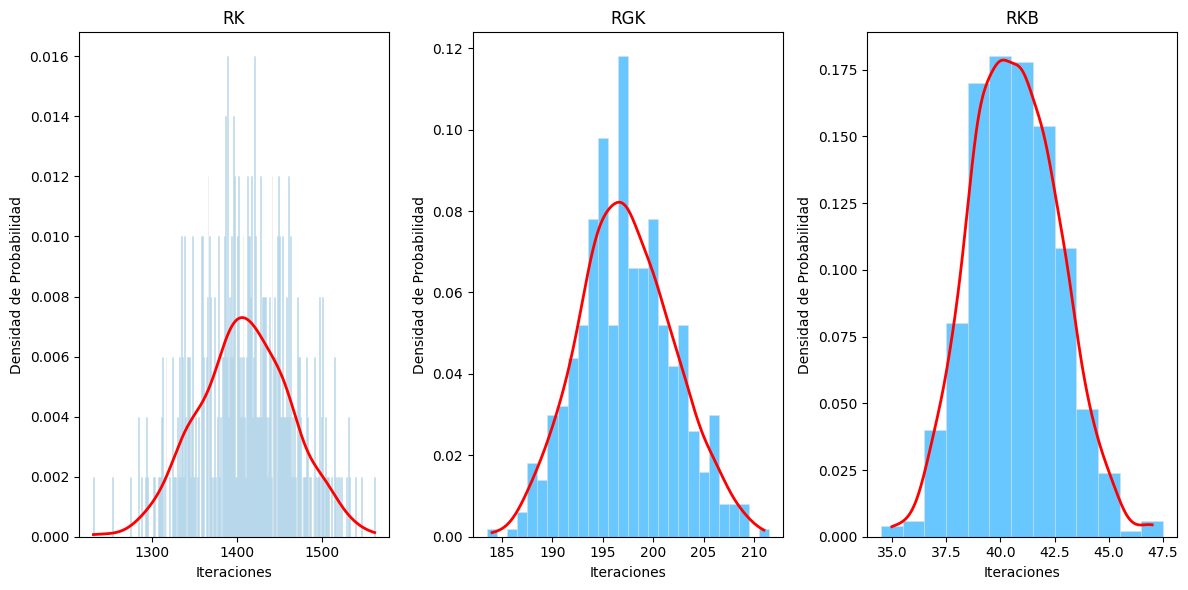

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Create the figure and axes
fig, axes = plt.subplots(1, 3,  tight_layout=True)

# Plot the first histogram
axes[0].hist(iterations_RK, bins=np.arange(min(iterations_RK), max(iterations_RK) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# KDE
kde = gaussian_kde(iterations_RK)
x_vals = np.linspace(min(iterations_RK), max(iterations_RK), 500)  # Adjust 500 for smoother/coarser plot
axes[0].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[0].set_title('RK')
axes[0].set_xlabel('Iteraciones')
axes[0].set_ylabel('Densidad de Probabilidad')

# Plot the second histogram
axes[1].hist(iterations_GRK, bins=np.arange(min(iterations_GRK), max(iterations_GRK) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
# KDE
kde = gaussian_kde(iterations_GRK)
x_vals = np.linspace(min(iterations_GRK), max(iterations_GRK), 500)  # Adjust 500 for smoother/coarser plot
axes[1].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[1].set_title('RGK')
axes[1].set_xlabel('Iteraciones')
axes[1].set_ylabel('Densidad de Probabilidad')

# Plot the third histogram
axes[2].hist(iterations_RKB, bins=np.arange(min(iterations_RKB), max(iterations_RKB) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# KDE
kde = gaussian_kde(iterations_RKB)
x_vals = np.linspace(min(iterations_RKB), max(iterations_RKB), 500)  # Adjust 500 for smoother/coarser plot
axes[2].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[2].set_title('RKB')
axes[2].set_xlabel('Iteraciones')
axes[2].set_ylabel('Densidad de Probabilidad')

r = np.array(iterations_RK)
print("Random Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")

r = np.array(iterations_GRK)
print("Random Greedy Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")

r = np.array(iterations_RKB)
print("Random  Block Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")


# Show the plot
plt.show()

Ahora para el caso inconsistente

In [ ]:
def frecuency_REK(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000):
  # Invariant variables
  m, d = A.shape
  A_frob = torch.norm(A, p='fro')**2
  probs_p = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])
  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])
  x0_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  res_backup = torch.norm(b - A @ x0_backup)/torch.norm(b)

  frecuency = []
  while max_runs > 0:
    # Init variables for new run
    k = 0
    z = b.clone()
    x = x0_backup.clone()
    r = res_backup.clone()
    while r > tol and k < max_iters:
      i = torch.multinomial(probs_p, 1)[0]
      j = torch.multinomial(probs_q, 1)[0]
      a_i = A[i]
      a_j = A[:, j]

      z = z - (torch.dot(a_j, z)/torch.sum(a_j**2))*a_j
      x += ((b[i] - z[i] - torch.dot(a_i, x)) /torch.sum(a_i**2)) * a_i

      r = torch.norm(b - A @ x)/torch.norm(b)
      k += 1

    frecuency.append(k)
    max_runs -= 1

  return frecuency

In [ ]:
def frecuency_GREK(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000):
  # Invariant variables
  m, d = A.shape
  A_frob = torch.norm(A, p='fro')**2
  A_frob_inv = 1/A_frob

  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])
  row_norms = torch.sum(A**2, dim=1)  # Auxiliary vector

  x0_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  res_backup = b - torch.matmul(A, x0_backup)
  r_norm_backup = torch.sum(res_backup**2)
  r_squared_backup = res_backup**2
  B = torch.mm(A, A.t())

  frecuency = []
  while max_runs > 0:
    # Init variables for new run
    k = 0
    z = b.clone()
    x = x0_backup.clone()
    r = res_backup.clone()
    r_norm = r_norm_backup
    r_squared = r_squared_backup
    k = 0
    while r_norm > tol and k < max_iters:
      # Get epsilon
      l = r_squared / row_norms
      eps = 0.5*(1/r_norm * torch.max(l) + A_frob_inv)

      #Check if ik doesnt belong to the index set Uik
      mask = r_squared < eps * r_norm * row_norms
      r_aux = r.clone()
      r_aux[mask] = 0

      #Compute probabilities array
      probs = (r_aux**2) / torch.sum(r_aux**2)

      #Project row
      i = torch.multinomial(probs, 1)[0]
      j = torch.multinomial(probs_q, 1)[0]
      a_i = A[i]
      a_j = A[:, j]

      z = z - (torch.dot(a_j, z)/torch.sum(a_j**2))*a_j
      x += ((b[i] - z[i] - torch.dot(a_i, x)) /torch.sum(a_i**2)) * a_i

      #r = r - (r[i]/row_norms[i])*B[i]
      r = b - z - torch.matmul(A, x)
      r_norm = torch.sum(r**2)
      r_squared = r**2

      k+=1

    frecuency.append(k)
    max_runs -= 1
  return frecuency

In [ ]:
def frecuency_RKDD(A, b, x0=None, tol=tol, max_iters=1e5, max_runs=1000, block_size=25):
  m, d = A.shape
  x0_backup = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  r_backup = torch.norm(b - torch.matmul(A, x0_backup))

  z_backup = b.clone()
  A_frob = torch.norm(A, p='fro')**2

  # Calculate probabilities for row blocks
  probs_p = torch.zeros((m + block_size - 1) // block_size )  # Initialize probabilities
  for i_block in range(0, m, block_size):
      block = A[i_block:min(i_block + block_size, m)]
      block_norm_sq = torch.sum(torch.norm(block, dim=1)**2)
      probs_p[i_block // block_size] = block_norm_sq / A_frob
  probs_p /= torch.sum(probs_p)

  # Calculate probabilities for column blocks
  probs_q = torch.zeros((d + block_size - 1) // block_size )
  for j_block in range(0, d, block_size):
      block = A[:, j_block:min(j_block + block_size, d)]
      block_norm_sq = torch.sum(torch.norm(block, dim=0)**2)
      probs_q[j_block // block_size] = block_norm_sq / A_frob
  probs_q /= torch.sum(probs_q)

  frecuency = []
  while max_runs > 0:
    # Init variables for new run
    k = 0
    z = z_backup.clone()
    x = x0_backup.clone()
    r = r_backup.clone()
    while r > tol and k < max_iters:
        i_block = torch.multinomial(probs_p, 1)[0] * block_size
        j_block = torch.multinomial(probs_q, 1)[0] * block_size

        i_end = min(i_block + block_size, m)
        j_end = min(j_block + block_size, d)

        A_i = A[i_block:i_end]  # Row block
        A_j = A[:, j_block:j_end]  # Column block

        # Project onto the blocks
        z -=  A_j @ (torch.linalg.pinv(A_j) @ z)
        x += torch.linalg.pinv(A_i) @  (b[i_block:i_end] - z[i_block:i_end] - A_i @ x)

        k += 1
        r = torch.norm(b - A @ x) / torch.norm(b)

    frecuency.append(k)
    max_runs -= 1
  return frecuency

In [ ]:
import scipy.io as sio
import numpy as np
import torch

A, b = generate_SEL(4000, 50, noiseLev=0.05, noise=True)
A = torch.from_numpy(A).to(device)
b = torch.from_numpy(b).to(device)

max_runs = 500
iterations_REK = frecuency_REK(A, b, max_runs=max_runs)
iterations_GREK = frecuency_GREK(A, b, max_runs=max_runs)
iterations_RKDD = frecuency_RKDD(A, b, max_runs=max_runs)

In [ ]:
print("REK: ")
stat, p = test_normality(iterations_REK)
print("p: ", p, "stat: ", stat)
print("GREK: ")
stat, p = test_normality(iterations_GREK)
print("p: ", p, "stat: ", stat)
print("RKDD: ")
stat, p = test_normality(iterations_RKDD)
print("p: ", p, "stat: ", stat)

REK: 
Se rechaza la hipótesis nula. Los datos no parecen seguir una distribución normal.
p:  0.02680601376395379 stat:  7.238258044921107
GREK: 
Se rechaza la hipótesis nula. Los datos no parecen seguir una distribución normal.
p:  9.985193502172146e-08 stat:  32.23915479597244
RKDD: 
Se rechaza la hipótesis nula. Los datos no parecen seguir una distribución normal.
p:  3.5663483642176436e-06 stat:  25.08793670564855


Random Extended Kacmarz
 - Promedio:  1582.078
 - Desviación estándar:  73.53837036540855
 - Varianza:  5407.891916 

Random Greedy Extended Kacmarz
 - Promedio:  1229.878
 - Desviación estándar:  103.77444346273316
 - Varianza:  10769.135116000001 

Random Double Block Kacmarz
 - Promedio:  56.526
 - Desviación estándar:  7.029461145777819
 - Varianza:  49.413324 



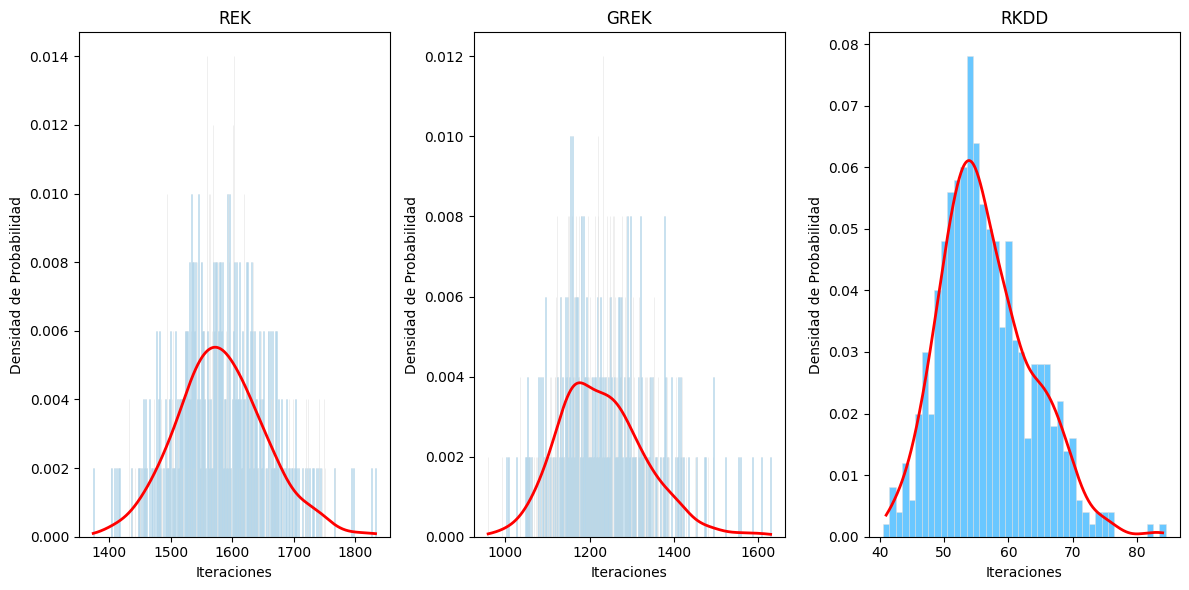

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Create the figure and axes
fig, axes = plt.subplots(1, 3,  tight_layout=True)

# Plot the first histogram
axes[0].hist(iterations_REK, bins=np.arange(min(iterations_REK), max(iterations_REK) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# KDE
kde = gaussian_kde(iterations_REK)
x_vals = np.linspace(min(iterations_REK), max(iterations_REK), 500)  # Adjust 500 for smoother/coarser plot
axes[0].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[0].set_title('REK')
axes[0].set_xlabel('Iteraciones')
axes[0].set_ylabel('Densidad de Probabilidad')

# Plot the second histogram
axes[1].hist(iterations_GREK, bins=np.arange(min(iterations_GREK), max(iterations_GREK) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
# KDE
kde = gaussian_kde(iterations_GREK)
x_vals = np.linspace(min(iterations_GREK), max(iterations_GREK), 500)  # Adjust 500 for smoother/coarser plot
axes[1].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[1].set_title('GREK')
axes[1].set_xlabel('Iteraciones')
axes[1].set_ylabel('Densidad de Probabilidad')

# Plot the third histogram
axes[2].hist(iterations_RKDD, bins=np.arange(min(iterations_RKDD), max(iterations_RKDD) + 2) - 0.5,
             density = True, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# KDE
kde = gaussian_kde(iterations_RKDD)
x_vals = np.linspace(min(iterations_RKDD), max(iterations_RKDD), 500)  # Adjust 500 for smoother/coarser plot
axes[2].plot(x_vals, kde(x_vals), color='red', linewidth=2, label="KDE")

axes[2].set_title('RKDD')
axes[2].set_xlabel('Iteraciones')
axes[2].set_ylabel('Densidad de Probabilidad')

r = np.array(iterations_REK)
print("Random Extended Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")

r = np.array(iterations_GREK)
print("Random Greedy Extended Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")

r = np.array(iterations_RKDD)
print("Random Double Block Kacmarz")
print(" - Promedio: ", np.mean(r))
print(" - Desviación estándar: ", np.std(r) )
print(" - Varianza: ", np.var(r), "\n")


# Show the plot
plt.show()

## Experimento 2: Comparación de los Métodos para resolver SEL consistentes e incosistentes

Para este experimento utilizaremos data sintética

In [ ]:
import pandas as pd

def format_cell(iterations, time):
  return str(iterations) + " / " + str(round(time, 3))

def compare_methods_SEL(num_runs=10, noiseLev=0.1):
  # Dimentions
  row_options = [1000, 2000, 4000, 8000, 16000, 32000]
  col_options = [10, 20, 50, 100, 200, 500, 1000]

  results = []
  for n, m in zip(row_options, col_options):
    A, b = generate_SEL(n, m, noiseLev)
    cond = np.linalg.cond(A)

    # Convert into tensors
    A = torch.from_numpy(A).to(device)
    b = torch.from_numpy(b).to(device)

    t1, iters1 = benchmark_MAP(classic_kacmarz, A, b, num_runs)
    t2, iters2 = benchmark_MAP(random_kacmarz, A, b, num_runs)
    t3, iters3 = benchmark_MAP(greedy_random_kacmarz, A, b, num_runs)
    t4, iters4 = benchmark_MAP(random_block_kacmarz, A, b, num_runs)

    start_time = time.time()
    _, iters5 = conjugate_gradient_cimmino(A, b)
    end_time = time.time()
    t5 = end_time - start_time

    results.append([str(n) + " x " + str(m), cond, format_cell(iters1, t1), format_cell(iters2, t2),
                    format_cell(iters3, t3), format_cell(iters4, t4), format_cell(iters5, t5)
                    ])

  return results

In [ ]:
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
results = compare_methods_SEL(num_runs=1)
pd.DataFrame(results, columns=["m x n", "Cond(A)","RBK"])

,m x n,Cond(A),RBK
0,1000 x 10,1.459360,40 / 0.083
1,2000 x 20,1.670350,80 / 0.084
2,4000 x 50,2.318967,160 / 0.207
3,8000 x 100,3.069652,320 / 0.842
4,16000 x 200,4.160209,640 / 5.133
5,32000 x 500,6.594040,1280 / 17.554


In [ ]:
results = compare_methods_SEL(num_runs=5)
pd.DataFrame(results, columns=["m x n", "Cond(A)", "KC", "RK", "RGK", "RBK", "CCG"])

### Comparación de los métodos para resolver sistemas incosistentes

In [ ]:
import numpy as np
import torch
import random
import time

def format_cell(iterations, time):
  return str(iterations) + " / " + str(round(time, 3))

def compare_methods_LSP(num_runs=10, noiseLev=0.1):
  # Dimentions
  row_options = [1000, 2000, 4000]
  col_options = [10, 20, 50, 100]

  results = []
  for n, m in zip(row_options, col_options):
    A, b = generate_SEL(n, m, noiseLev, noise=True)
    cond = np.linalg.cond(A)

    # Convert into tensors
    A = torch.from_numpy(A).to(device)
    b = torch.from_numpy(b).to(device)

    t1, iters1 = benchmark_MAP(extended_random_kacmarz, A, b, num_runs)
    t2, iters2 = benchmark_MAP(extended_greedy_random_kacmarz, A, b, num_runs)
    t3, iters3 = benchmark_MAP(extended_random_kacmarz_double_block, A, b, num_runs)

    start_time = time.time()
    _, iters5 = conjugate_gradient_cimmino(A, b)
    end_time = time.time()
    t5 = end_time - start_time

    results.append([str(n) + " x " + str(m), cond, format_cell(iters1, t1), format_cell(iters2, t2),
                    format_cell(iters3, t3), format_cell(iters5, t5)
                    ])

  return results

In [ ]:
results = compare_methods_LSP(num_runs=3, noiseLev=0.05)
pd.DataFrame(results, columns=["m x n", "Cond(A)", "RKE", "RGKE", "RKDD", "Cimmino-CG"])

,m x n,Cond(A),RKE,RGKE,RKDD,Cimmino-CG
0,1000 x 10,1.441255,358 / 0.153,159 / 0.061,2 / 0.003,24 / 0.003
1,2000 x 20,1.644819,788 / 0.324,407 / 0.25,2 / 0.009,40 / 0.011
2,4000 x 50,2.318143,1680 / 1.114,1224 / 0.722,51 / 0.178,33 / 0.02
3,8000 x 100,3.080821,3217 / 3.346,2822 / 3.049,142 / 1.205,30 / 0.062
4,16000 x 200,4.172211,6248 / 20.991,5909 / 21.305,325 / 6.382,37 / 0.627
5,32000 x 500,6.579148,15924 / 233.83,16512 / 249.031,818 / 44.375,24 / 4.519


In [ ]:
results = compare_methods_LSP(num_runs=3, noiseLev=0.05)
pd.DataFrame(results, columns=["m x n", "Cond(A)", "RKE", "RGKE", "RKDD", "CCG"])

<ipython-input-21-cc4dbc2074bb>:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  v = torch.dot(r.T, r)


,m x n,Cond(A),RKE,RGKE,RKDD,CCG
0,1000 x 10,1.420173,362 / 0.468,127 / 0.242,2 / 0.116,17 / 0.018
1,2000 x 20,1.668016,627 / 0.545,377 / 0.402,2 / 0.061,41 / 0.018
2,4000 x 50,2.273620,1469 / 1.363,1111 / 1.012,50 / 0.599,36 / 0.01
3,8000 x 100,3.056626,3192 / 3.124,2980 / 3.098,137 / 1.934,56 / 0.016
4,16000 x 200,4.203844,6290 / 9.135,5940 / 6.439,309 / 4.204,105 / 0.062
5,32000 x 500,6.579442,14738 / 23.757,17032 / 25.98,825 / 14.269,24 / 0.067


Matrices tomadas de:


*   **The original Harwell-Boeing collection.**  Iain Duff, Roger  Grimes, and John Lewis. Duff, I. S. and R. G. Grimes and J. G. Lewis,
Sparse Matrix Problems, ACM Trans. on Mathematical Software,
vol 14, no. 1, pp 1-14, 1989



In [ ]:
import scipy.io as sio
import numpy as np
import torch
import time

def format_cell(iterations, time):
  return str(iterations) + " / " + str(round(time, 3))

def compare_methods_LSP_RP(num_runs=1):
  # Matrices names
  matrices_names = [ "well1850", "well1033.mat","illc1850.mat", "illc1033.mat"]

  results = []
  for matrix in matrices_names:
    mat_file = sio.loadmat(matrix)
    struct = mat_file['Problem']

    # Construct problem
    A = struct['A'][0, 0].todense()
    cond = np.linalg.cond(A)
    m, n = A.shape
    b = struct['b'][0, 0]

    # Send to device
    A = torch.from_numpy(A).to(device)
    b = torch.from_numpy(b).squeeze(1).to(device)

    t1, iters1 = benchmark_MAP(extended_random_kacmarz, A, b, num_runs)
    t2, iters2 = benchmark_MAP(extended_greedy_random_kacmarz, A, b, num_runs)
    t3, iters3 = benchmark_MAP(extended_random_kacmarz_double_block, A, b, num_runs)

    start_time = time.time()
    _, iters4 = conjugate_gradient_cimmino(A, b)
    end_time = time.time()
    t4 = end_time - start_time

    results.append([str(n) + " x " + str(m), cond, format_cell(iters1, t1), format_cell(iters2, t2),
                    format_cell(iters3, t3), format_cell(iters4, t4)
                    ])

  return results

results = compare_methods_LSP_RP(num_runs=1)
pd.DataFrame(results, columns=["m x n", "Cond(A)", "RKE", "RGKE", "RKDD", "CCG"])

## Test Incremental RKE

In [ ]:
def CGCB(A, B, X0=None, max_iter=10000, tol=1e-6):
  m, n = A.shape
  m, p = B.shape
  X = X0 if X0 is not None else torch.ones((n, p), dtype=A.dtype, device=A.device).to(device)

  # Re-use computations
  AX = torch.matmul(A, X)
  a_norms = torch.linalg.norm(A, ord=2, dim=1)**2

  # For each LPS problem
  proyB = torch.zeros((n, p), device=device)
  scaledA = A / a_norms[:, None]

  for i in range(p):
    # 1. Obtain points ci beloging to the hyperplanes by proyecting the vector x0 on them for each f
    C = X[:, i] - ((AX[: , i] - B[:, i])[:, None] * scaledA)
    # 2. Obtain the sum of the orthogonal proyections to all the hyperplanes of the points ci
    proyB[:, i] =  torch.matmul(scaledA.T, torch.sum(A * C, dim=1))
  B = proyB

  # Initialization of GC variables
  AX = torch.matmul(scaledA.T, AX)
  R = B - AX      # Residual
  P = R.clone()   # Search direction
  R_old = R.T @ R

  A = A.T @ scaledA #Substitute Matrix A to free space
  for iter_count in range(max_iter):
      H = A @ P
      Ak = torch.linalg.pinv(P.T @ H) @ R_old    # Step size matrix
      X += P @ Ak
      R -= H @ Ak

      res = torch.max(torch.linalg.norm(R,axis=0))
      if res <= tol:
            break

      RTR = R.T @ R
      Phi =  torch.linalg.pinv(R_old) @ RTR
      P = R + P @ Phi
      R_old = RTR

  return X, iter_count

Generate random incosistent SEL

In [ ]:
A, b = generate_SEL(10000, 250, 0.1, noise=True)
A = torch.from_numpy(A).to(device)
b = torch.from_numpy(b).to(device)

In [ ]:
import time

firstIter = []
firstTime = []
secondIter = []
secondTime = []
thidIter = []
thirdtTime = []
fourthIter = []
fourthTime = []
fifthIter = []
fifthTime = []
completeIter1 = []
complete1Time = []
completeIter2 = []
complete2Time = []
completeIter3 = []
complete3Time = []
completeIter4 = []
complete4Time = []
for _ in range(20):
  t1 = time.time()
  x0, iter = extended_random_kacmarz(A[:5000], b[:5000])
  t2 = time.time()
  firstTime.append(t2-t1)
  firstIter.append(iter)

  t1 = time.time()
  x, iter = extended_random_kacmarz(A[:7000], b[:7000], x0=x0)
  t2 = time.time()
  secondTime.append(t2-t1)
  secondIter.append(iter)

  t1 = time.time()
  x, iter = extended_random_kacmarz(A[:8000], b[:8000], x0=x0)
  t2 = time.time()
  thirdtTime.append(t2-t1)
  thidIter.append(iter)

  t1 = time.time()
  x, iter = extended_random_kacmarz(A[:9000], b[:9000], x0=x0)
  t2 = time.time()
  fourthTime.append(t2-t1)
  fourthIter.append(iter)

  t1 = time.time()
  x, iter = extended_random_kacmarz(A, b, x0=x0)
  t2 = time.time()
  fifthTime.append(t2-t1)
  fifthIter.append(iter)

  t1 = time.time()
  W, iter = extended_random_kacmarz(A[:7000], b[:7000])
  t2 = time.time()
  complete1Time.append(t2-t1)
  completeIter1.append(iter)

  t1 = time.time()
  W, iter = extended_random_kacmarz(A[:8000], b[:8000])
  t2 = time.time()
  complete2Time.append(t2-t1)
  completeIter2.append(iter)

  t1 = time.time()
  W, iter = extended_random_kacmarz(A[:9000], b[:9000])
  t2 = time.time()
  complete3Time.append(t2-t1)
  completeIter3.append(iter)

  t1 = time.time()
  W, iter = extended_random_kacmarz(A, b)
  completeIter4.append(iter)
  t2 = time.time()
  complete4Time.append(t2-t1)

In [ ]:
print(np.mean(firstIter))
print(np.mean(firstTime), "\n")

print(np.mean(secondIter))
print(np.mean(secondTime), "\n")

print(np.mean(thidIter))
print(np.mean(thirdtTime), "\n")

print(np.mean(fourthIter))
print(np.mean(fourthTime), "\n")

print(np.mean(fifthIter))
print(np.mean(fifthTime), "\n")

print(np.mean(completeIter1))
print(np.mean(complete1Time), "\n")

print(np.mean(completeIter2))
print(np.mean(complete2Time), "\n")

print(np.mean(completeIter3))
print(np.mean(complete3Time), "\n")

print(np.mean(completeIter4))
print(np.mean(complete4Time), "\n")

7480.1
9.635739886760712 

6051.5
11.269969069957734 

3854.55
8.448113942146302 

3434.15
8.453564488887787 

1367.85
3.99384526014328 

7096.35
13.071707427501678 

7012.8
15.024392664432526 

6889.45
17.12162811756134 

6875.35
19.149029409885408 

